微调_热狗识别

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

我们创建两个实例来分别读取训练和测试数据集中的所有图像文件。

In [3]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir,'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir,'test'))

下面显示了前8个正类样本图片和最后8张负类样本图片。正如所看到的，图像的大小和纵横比各有不同。

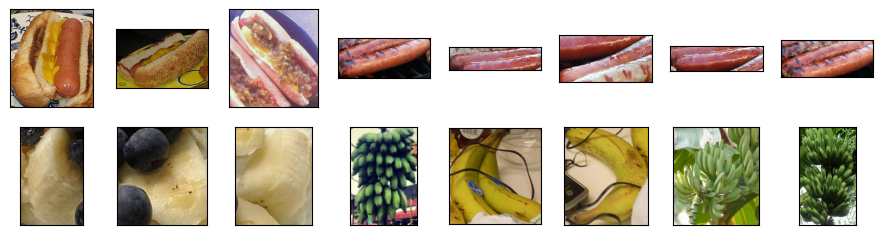

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

在训练期间，我们首先从图像中裁切随机大小和随机长宽比的区域，然后将该区域缩放为224×224输入图像。 在测试过程中，我们将图像的高度和宽度都缩放到256像素，然后裁剪中央224×224区域作为输入。 此外，对于RGB（红、绿和蓝）颜色通道，我们分别标准化每个通道。 具体而言，该通道的每个值减去该通道的平均值，然后将结果除以该通道的标准差。

```
这些数值是ImageNet数据集上统计得出的：
均值 [0.485, 0.456, 0.406]：分别对应R、G、B通道在ImageNet上的平均值
标准差 [0.229, 0.224, 0.225]：分别对应R、G、B通道在ImageNet上的标准差
标准化公式：(pixel_value - mean) / std

Resize + CenterCrop的优势为什么选择256而不是224？
这是经验性选择，来自ImageNet相关研究：
给裁剪留余地：256-224=32像素的"缓冲区"
避免过度缩放：直接缩放到224可能损失过多细节
历史经验：在AlexNet、ResNet等经典网络中被证明有效
torchvision.transforms.Resize(256) # 短边256，保持长宽比

In [5]:
# 使用RGB通道的均值和标准差，以标准化每个通道
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),    # 随机裁剪缩放
    torchvision.transforms.RandomHorizontalFlip(),    # 随机水平翻转  
    torchvision.transforms.ToTensor(),                # 转为tensor
    normalize])                                       # 标准化

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),        # 缩放到256×256
    torchvision.transforms.CenterCrop(224),           # 中心裁剪到224×224
    torchvision.transforms.ToTensor(),                # 转为tensor
    normalize])                                       # 标准化

定义和初始化模型

我们使用在ImageNet数据集上预训练的ResNet-18作为源模型。 在这里，我们指定pretrained=True以自动下载预训练的模型参数。 如果首次使用此模型，则需要连接互联网才能下载。

In [6]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

D:\anaconda3\envs\lee_course_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\lee_course_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\yukot/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


预训练的源模型实例包含许多特征层和一个输出层fc。 此划分的主要目的是促进对除输出层以外所有层的模型参数进行微调。 下面给出了源模型的成员变量fc。

In [9]:
pretrained_net.fc
# 查看最后的全连接层
# 输出：Linear(in_features=512, out_features=1000, bias=True)
# fc是"Fully Connected"的缩写，这是ResNet-18的最后一层

Linear(in_features=512, out_features=1000, bias=True)

```
ResNet-18 = 1 + 2×2 + 2×2 + 2×2 + 2×2 + 1 = 18层
具体分解：
1. conv1 (1层)              # 第1层
2. layer1: 2个BasicBlock   # 第2-3层，第4-5层  
3. layer2: 2个BasicBlock   # 第6-7层，第8-9层
4. layer3: 2个BasicBlock   # 第10-11层，第12-13层
5. layer4: 2个BasicBlock   # 第14-15层，第16-17层
6. fc (1层)                # 第18层

# ImageNet Top-1 准确率（大致）：
imagenet_results = {
    'ResNet-18': '69.8%',
    'ResNet-34': '73.3%', 
    'ResNet-50': '76.1%',
    'ResNet-101': '77.4%',
    'ResNet-152': '78.3%'
}

初始化模型

In [10]:
# 加载预训练模型
# 创建一个ResNet-18模型，并加载ImageNet预训练权重
finetune_net = torchvision.models.resnet18(pretrained=True)
# 替换分类层
# 把原来的1000分类层替换成2分类层
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
# 权重初始化
# 作用：用Xavier初始化方法初始化新分类层的权重
# 这里我们只对最后一层fc的weight做初始化
nn.init.xavier_uniform_(finetune_net.fc.weight);

微调模型

首先，我们定义了一个训练函数train_fine_tuning，该函数使用微调，因此可以多次调用。

```
param_group=False：统一学习率
所有参数使用相同的学习率
param_group=True：分组学习率

In [11]:
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

开始训练

loss 0.206, train acc 0.928, test acc 0.932
384.2 examples/sec on [device(type='cuda', index=0)]


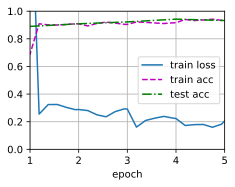

In [12]:
train_fine_tuning(finetune_net, 5e-5)

测试

🚀 开始单张图片预测...
✅ 成功加载图片: ../img/hotdogtes1.jpg
📐 原始图片尺寸: (1157, 682)
📐 预处理后尺寸: torch.Size([3, 224, 224])
💻 输入张量形状: torch.Size([1, 3, 224, 224])

🎯 预测结果:
📸 图片: hotdogtes1.jpg
🏷️  预测类别: not_hotdog
📊 置信度: 0.5116 (51.16%)

📋 所有类别概率:
  hotdog: 0.4884 (48.84%)
  not_hotdog: 0.5116 (51.16%)


C:\Users\yukot\AppData\Local\Temp\ipykernel_14948\1462064363.py:71: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from current font.
  plt.tight_layout()
C:\Users\yukot\AppData\Local\Temp\ipykernel_14948\1462064363.py:71: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from current font.
  plt.tight_layout()
C:\Users\yukot\AppData\Local\Temp\ipykernel_14948\1462064363.py:71: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()


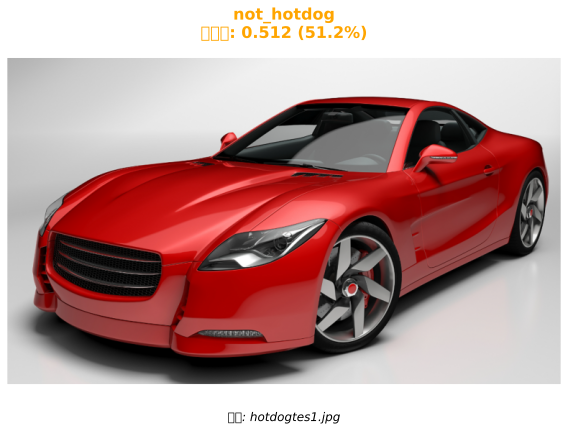


✅ 预测完成!


In [16]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def predict_single_image(net, image_path, test_augs, show_image=True):
    """预测单张图片"""
    
    class_names = ['hotdog', 'not_hotdog']  # 根据你的实际类别调整
    net.eval()
    device = next(iter(net.parameters())).device
    
    try:
        # 加载图片
        image = Image.open(image_path).convert('RGB')
        print(f"✅ 成功加载图片: {image_path}")
        print(f"📐 原始图片尺寸: {image.size}")
        
        # 预处理
        processed_image = test_augs(image)
        print(f"📐 预处理后尺寸: {processed_image.shape}")
        
        # 添加batch维度并移到设备
        input_tensor = processed_image.unsqueeze(0).to(device)
        print(f"💻 输入张量形状: {input_tensor.shape}")
        
        # 预测
        with torch.no_grad():
            output = net(input_tensor)
            probabilities = torch.softmax(output, dim=1)[0]
            predicted_idx = probabilities.argmax().item()
            confidence = probabilities[predicted_idx].item()
        
        # 结果
        result = {
            'predicted_class': class_names[predicted_idx],
            'confidence': confidence,
            'all_probabilities': {
                class_names[i]: probabilities[i].item() 
                for i in range(len(class_names))
            }
        }
        
        # 打印详细结果
        print(f"\n🎯 预测结果:")
        print(f"📸 图片: {image_path.split('/')[-1]}")
        print(f"🏷️  预测类别: {result['predicted_class']}")
        print(f"📊 置信度: {confidence:.4f} ({confidence*100:.2f}%)")
        print(f"\n📋 所有类别概率:")
        for class_name, prob in result['all_probabilities'].items():
            print(f"  {class_name}: {prob:.4f} ({prob*100:.2f}%)")
        
        # 可视化
        if show_image:
            plt.figure(figsize=(8, 6))
            plt.imshow(image)
            plt.axis('off')
            
            # 根据置信度设置颜色
            color = 'green' if confidence > 0.7 else 'orange' if confidence > 0.5 else 'red'
            
            title = f"{result['predicted_class']}\n置信度: {confidence:.3f} ({confidence*100:.1f}%)"
            plt.title(title, fontsize=16, color=color, weight='bold', pad=20)
            
            # 添加文件名
            file_name = image_path.split('/')[-1]
            plt.figtext(0.5, 0.02, f"文件: {file_name}", ha='center', fontsize=12, style='italic')
            
            plt.tight_layout()
            plt.show()
        
        return result
        
    except FileNotFoundError:
        print(f"❌ 错误: 找不到图片文件 {image_path}")
        return None
    except Exception as e:
        print(f"❌ 处理图片时出错: {e}")
        return None

# 使用示例
print("🚀 开始单张图片预测...")
result = predict_single_image(finetune_net, '../img/hotdogtes1.jpg', test_augs)

if result:
    print(f"\n✅ 预测完成!")
else:
    print(f"\n❌ 预测失败!")